# Example 4: Simulating the Earliest Possible Sowing Date for Millet in Niger taking into consideration plantlet survival



## Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

## Simulation parameters

In [2]:
# weather and rainfall data path
rainfall_data_path = "/mnt/d/climate_database/CHIRPS_v2.0_Africa_niger/"  
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/"

# parameter files
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# simulation parameters
duration = 220 # days
water_threshold = 9 # mm
date_start = datetime.date(2014,1,1)


# in the classic model, the crop is started with testing_for_initialisation
# If numPhase is 0, if the current day is equal or above the sowing date, and
# if surface_tank_stock is above the threshold for sowing, we initiate the
# crop
# which means the paramITK["DateSemis"] initially loaded from itk parameters must be defined correctly
# before being used in the initialize_simulation section
# the date_sowing is the date before which it is unconceivable that sowing can happen
# after that the model will anyways look for the first day where the surface_tank_stock is above the threshold to perform its first sowing
date_sowing = datetime.date(2014,4,1)

## Running the simulations

100%|██████████| 220/220 [03:46<00:00,  1.03s/it]


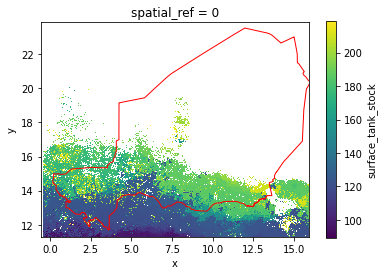

In [3]:
# retrieving the grid size from the rainfall data (this method will be deprecated in the future)
grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

## preparing the base dataset
# initialize empty xarray dataset to load base data
base_data = xr.Dataset()

# load rainfall and weather data
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

# load soil data using the iSDA method (uses more recent maps)
base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

# compute the day length
base_data = calc_day_length_raster_fast(base_data, date_start, duration)

## prepating simulation dataset
# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)
# bypassing the DateSemis parameter in the YAML file and setting it to the date of sowing
paramITK["DateSemis"] = date_sowing
paramITK["seuilEauSemis"] = water_threshold

# creating simulation xarray dataset by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

## running the model - classical version

    
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

## detection of ESSD
# creates a map of the first day at which the surface tank reaches the threshold
# argmax returns the index of the first True value along the time axis, that is here the DOY as simulation started on Jan. 1st
argmax = (data["surface_tank_stock"] > water_threshold).argmax(axis=0)
result = xr.where(argmax==0, np.nan, argmax)

# plotting the result map
result.plot()
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.show()

Mortality is managed by the MortaliteSarraV3 function.

Third, for numPhase equal or above 2, for days where nbJourCompte is lower
    than nbjTestSemis and where deltaBiomasseAerienne is negative, the nbjStress
    variable is incremented by 1. Thus, we count the number of days with
    negative deltaBiomasseAerienne since emergence as stress days.

    Finally, for days where nbjStress is equal or higher than
    seuilCstrMortality, the crop is reset by setting numPhase,
    root_tank_capacity and nbjStress to 0.

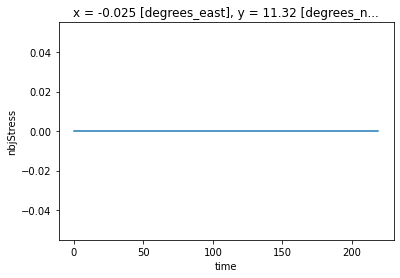

In [4]:
# we look at a point where there is a change in numPhase
data["nbjStress"][:,250,10].plot()

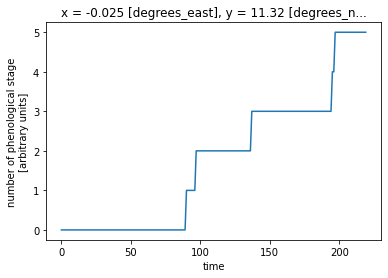

In [5]:
# we look at a point where there is a change in numPhase
data["numPhase"][:,250,10].plot()

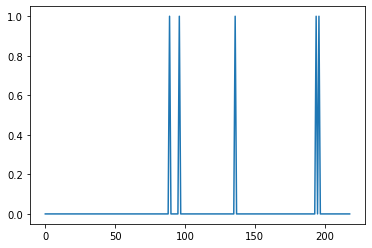

In [6]:
# we look at the doy where numPhase went to 0 to 1
plt.plot(np.diff(data["numPhase"], axis=0)[:,250,10])

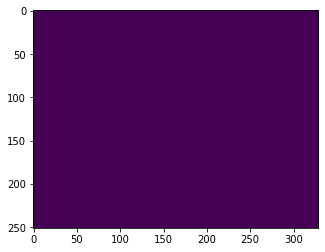

In [7]:
# on représente le nombre de fois ou sur le cycle il y a eu un retour en arrière dans la phénologie (mort de la plantule)
plt.imshow((np.diff(data["numPhase"], axis=0)<0).sum(axis=0))

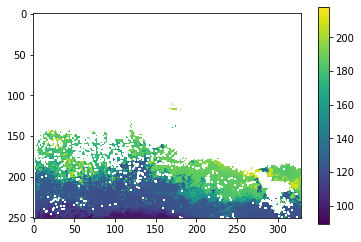

In [8]:
# and so we can make a map of where the first change occurs
result = np.diff(data["numPhase"], axis=0).argmax(axis=0)
plt.imshow(np.where(result==0, np.nan, result))
plt.colorbar()
plt.show()

In [9]:
argmax_tankstock = (data["surface_tank_stock"] > water_threshold).argmax(axis=0)
argmax_model = np.diff(data["numPhase"], axis=0).argmax(axis=0)

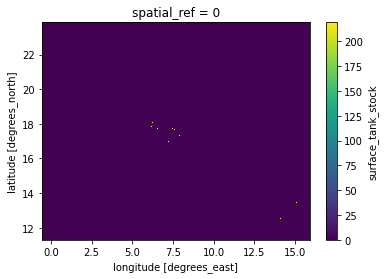

In [10]:
(argmax_tankstock - argmax_model).plot()